In [2]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 29.9 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


In [3]:
#importing all the libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [ ]:
# API key for Twelve Data
API_KEY = "YOUR_API_KEY_HERE"  # Replace with your actual API key

# Stock ticker symbol for NVIDIA
symbol = "NVDA"

In [5]:
# Twelve Data endpoint for historical time series
url = "https://api.twelvedata.com/time_series"

# Parameters for daily NVDA price data
params = {
    "symbol": symbol,
    "interval": "1day",
    "outputsize": 1000,  # ~4 years of daily data
    "apikey": API_KEY
}

# Send GET request to the API
response = requests.get(url, params=params)

# Convert response to JSON format
data = response.json()

# Check for API errors
if "values" not in data:
    raise ValueError(f"API error: {data}")


In [6]:
# Twelve Data endpoint for historical time series
url = "https://api.twelvedata.com/time_series"

# Parameters for daily NVDA price data
params = {
    "symbol": symbol,
    "interval": "1day",
    "outputsize": 1000,  # ~4 years of daily data
    "apikey": API_KEY
}

# Send GET request to the API
response = requests.get(url, params=params)

# Convert response to JSON format
data = response.json()

# Check for API errors
if "values" not in data:
    raise ValueError(f"API error: {data}")


In [7]:
# Convert JSON response into a raw DataFrame (no preprocessing yet)
nvda_raw = pd.DataFrame(data["values"])

# Inspect the raw data
nvda_raw.head()

,datetime,open,high,low,close,volume
0,2026-01-28,191.28999,192.35001,189.84000,191.53000,99338751
1,2026-01-27,187.24001,190,185.70000,188.52000,143233500
2,2026-01-26,187.16000,189.12000,185.99001,186.47000,124799600
3,2026-01-23,187.5,189.60001,186.82001,187.67000,142748100
4,2026-01-22,184.75,186.17000,183.92999,184.84000,139636600


In [8]:
nvda_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   datetime  1000 non-null   str  
 1   open      1000 non-null   str  
 2   high      1000 non-null   str  
 3   low       1000 non-null   str  
 4   close     1000 non-null   str  
 5   volume    1000 non-null   str  
dtypes: str(6)
memory usage: 47.0 KB


In [9]:
# Convert datetime column to pandas datetime format
nvda_raw["datetime"] = pd.to_datetime(nvda_raw["datetime"])

# Set datetime as the DataFrame index
nvda_raw.set_index("datetime", inplace=True)

# Convert all price and volume columns to numeric values
nvda_raw = nvda_raw.astype(float)

# Sort data from oldest to newest
nvda_raw.sort_index(inplace=True)

# Confirm changes
nvda_raw.info()
nvda_raw.head()


<class 'pandas.DataFrame'>
DatetimeIndex: 1000 entries, 2022-02-02 to 2026-01-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1000 non-null   float64
 1   high    1000 non-null   float64
 2   low     1000 non-null   float64
 3   close   1000 non-null   float64
 4   volume  1000 non-null   float64
dtypes: float64(5)
memory usage: 46.9 KB


,open,high,low,close,volume
datetime,,,,,
2022-02-02,25.794,25.817,24.553,25.242,543419000.0
2022-02-03,24.458,25.077,23.780,23.948,410178000.0
2022-02-04,23.972,24.635,23.632,24.319,354829000.0
2022-02-07,24.372,25.182,24.202,24.728,376868000.0
2022-02-08,24.359,25.230,23.980,25.108,410359000.0


In [26]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [10]:
# Calculate date three years ago from today
three_years_ago = datetime.now() - timedelta(days=365 * 3)

# Filter the dataset to include only the last three years
df = nvda_raw[nvda_raw.index >= three_years_ago]

# Display the filtered data
df.head()

,open,high,low,close,volume
datetime,,,,,
2023-01-30,19.950,20.140,19.150,19.162,488611000.0
2023-01-31,19.170,19.687,18.950,19.537,498017000.0
2023-02-01,19.691,21.192,19.611,20.943,660477000.0
2023-02-02,21.000,21.949,20.700,21.709,564276000.0
2023-02-03,21.000,21.745,20.789,21.100,429366000.0


In [11]:
# Save the final dataset to a CSV file for later use
df.to_csv("nvda_3y.csv")

## Train/Test Split

In [28]:
data = df["close"] 
train_size = int(len(data) * 0.8) 
train_data = data[:train_size] 
test_data = data[train_size:] 
print(f"Train: {len(train_data)} | Test: {len(test_data)}")

Train: 601 | Test: 151


## Fit and Predict

In [29]:
model = ExponentialSmoothing(train_data, trend='add', seasonal=None) 
model_fit = model.fit() 
predictions = model_fit.forecast(steps=len(test_data))

/Users/david/Desktop/StockPrediction/venv311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/david/Desktop/StockPrediction/venv311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/david/Desktop/StockPrediction/venv311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Metrics

In [31]:
import numpy as np

In [33]:
mape = mean_absolute_percentage_error(test_data.values, predictions.values)
rmse = np.sqrt(mean_squared_error(test_data.values, predictions.values))

print(f"MAPE = {mape*100:.2f}% | RMSE = ${rmse:.2f}")

MAPE = 11.05% | RMSE = $21.67


In [34]:
print("\n" + "="*60)
print("ACTUAL vs PREDICTED")
print("="*60)
print(f"{'Date':<12} {'Actual ($)':<15} {'Predicted ($)':<15} {'Error ($)':<15}")
print("-"*60)

for date, actual, pred in zip(test_data.index, test_data.values, predictions.values):
    error = abs(actual - pred)
    print(f"{date.strftime('%Y-%m-%d'):<12} ${actual:<14.2f} ${pred:<14.2f} ${error:<14.2f}")


ACTUAL vs PREDICTED
Date         Actual ($)      Predicted ($)   Error ($)      
------------------------------------------------------------
2025-06-24   $147.90         $144.38         $3.52          
2025-06-25   $154.31         $144.59         $9.72          
2025-06-26   $155.02         $144.80         $10.22         
2025-06-27   $157.75         $145.01         $12.74         
2025-06-30   $157.99         $145.21         $12.78         
2025-07-01   $153.30         $145.42         $7.88          
2025-07-02   $157.25         $145.63         $11.62         
2025-07-03   $159.34         $145.84         $13.50         
2025-07-07   $158.24         $146.05         $12.19         
2025-07-08   $160.00         $146.26         $13.74         
2025-07-09   $162.88         $146.46         $16.42         
2025-07-10   $164.10         $146.67         $17.43         
2025-07-11   $164.92         $146.88         $18.04         
2025-07-14   $164.07         $147.09         $16.98         
202

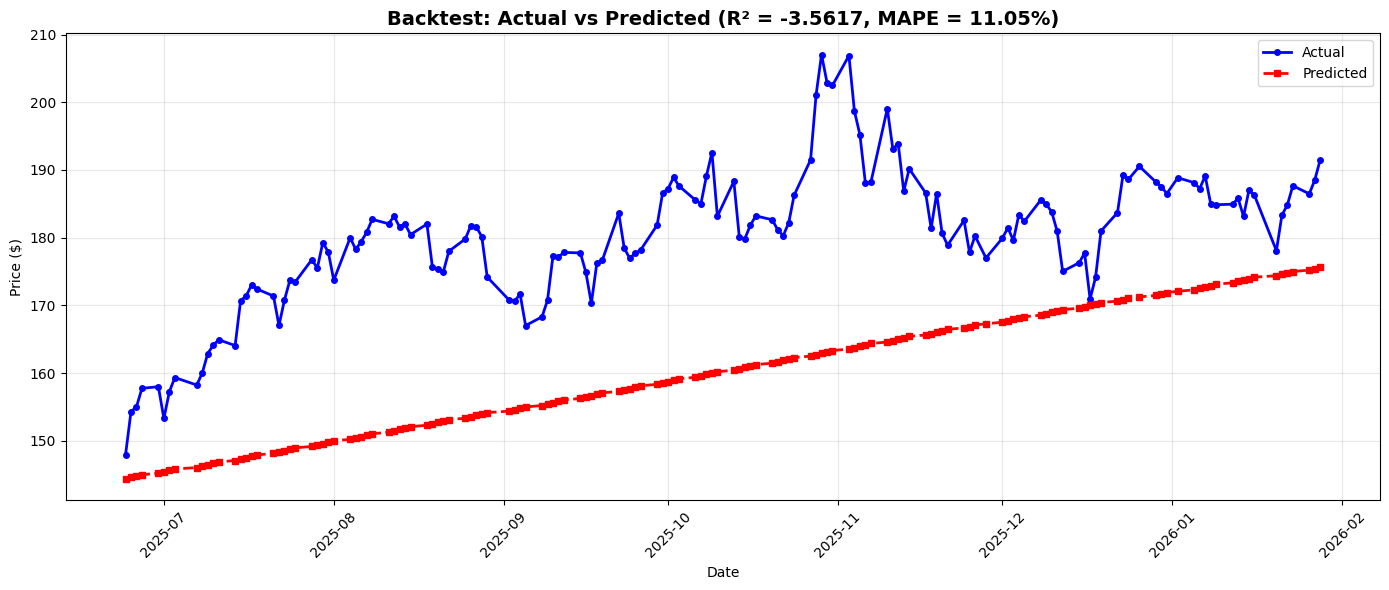

In [35]:
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data.values, 'b-', label='Actual', linewidth=2, marker='o', markersize=4)
plt.plot(test_data.index, predictions.values, 'r--', label='Predicted', linewidth=2, marker='s', markersize=4)
plt.title(f'Backtest: Actual vs Predicted (R² = {r2:.4f}, MAPE = {mape*100:.2f}%)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/Users/david/Desktop/StockPrediction/venv311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/david/Desktop/StockPrediction/venv311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



7-DAY FUTURE PRICE PREDICTION

Day   Date         Forecasted Price ($)
--------------------------------------------------
1     2026-01-29   $144.38             
2     2026-01-30   $144.59             
3     2026-01-31   $144.80             
4     2026-02-01   $145.01             
5     2026-02-02   $145.21             
6     2026-02-03   $145.42             
7     2026-02-04   $145.63             


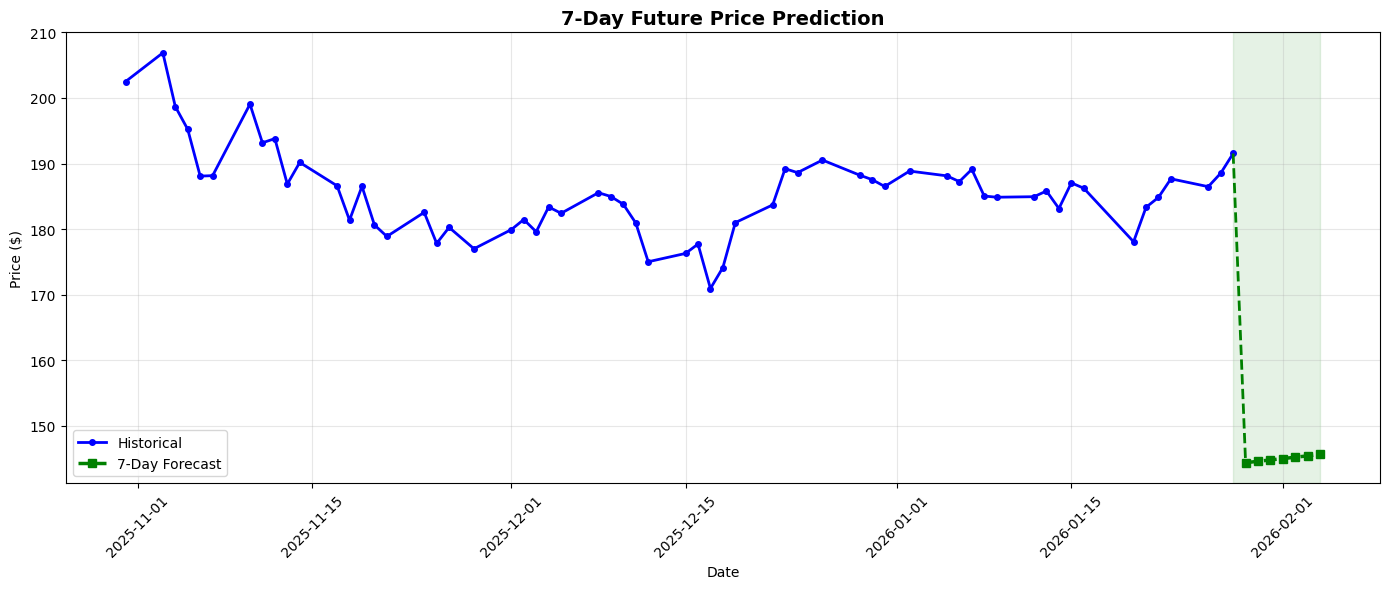


Current Price: $191.53
Day 7 Forecast: $145.63
Expected Change: -23.96%


In [37]:
# Forecast 7 days into the future
future_days = 7
future_forecast = model_fit.forecast(steps=future_days)

# Create future dates
future_dates = pd.date_range(
    start=data.index[-1] + pd.Timedelta(days=1),
    periods=future_days,
    freq='D'
)

# Print 7-day forecast
print("\n" + "="*50)
print("7-DAY FUTURE PRICE PREDICTION")
print("="*50)
print(f"\n{'Day':<5} {'Date':<12} {'Forecasted Price ($)':<20}")
print("-"*50)

for i, (date, price) in enumerate(zip(future_dates, future_forecast.values), 1):
    print(f"{i:<5} {date.strftime('%Y-%m-%d'):<12} ${price:<19.2f}")

print("="*50)

# Plot with future forecast
plt.figure(figsize=(14, 6))

# Plot last 60 days of actual data
recent_data = data.tail(60)
plt.plot(recent_data.index, recent_data.values, 'b-', label='Historical', linewidth=2, marker='o', markersize=4)

# Plot future forecast
plt.plot(future_dates, future_forecast.values, 'g--', label='7-Day Forecast', linewidth=2.5, marker='s', markersize=6)

# Connect last point to first forecast
plt.plot([data.index[-1], future_dates[0]], 
         [data.values[-1], future_forecast.values[0]], 
         'g--', linewidth=2)

# Shade forecast region
plt.axvspan(data.index[-1], future_dates[-1], alpha=0.1, color='green')

plt.title('7-Day Future Price Prediction', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary
print(f"\nCurrent Price: ${data.iloc[-1]:.2f}")
print(f"Day 7 Forecast: ${future_forecast.iloc[-1]:.2f}")
print(f"Expected Change: {((future_forecast.iloc[-1] - data.iloc[-1]) / data.iloc[-1] * 100):+.2f}%")